
# Linear Stacking & Blending Models — From Math to Code

**Goal:** A compact, hands‑on notebook that explains and implements **stacking** and **blending** (with a **linear** meta‑learner / blender) for regression.  
We'll use scikit‑learn's Diabetes dataset and compare several linear base models, then build stacked and blended ensembles.  

**What you'll learn**
- The math behind linear **stacking** and **blending**
- How to generate **out‑of‑fold (OOF)** predictions correctly
- How to implement a **linear meta‑learner** for stacking
- How to implement **blending** via a hold‑out set (simple weighted average and a learned linear blender)
- How to evaluate with RMSE / $R^2$ and visualize results



## 1) Theory (Concise)

### 1.1 Notation
We have training data $\{(\mathbf{x}_i, y_i)\}_{i=1}^{n}$ with $\mathbf{x}_i \in \mathbb{R}^d$ and target $y_i \in \mathbb{R}$.  
Assume $M$ base (level‑0) models $f_1,\ldots,f_M$. Their predictions for sample $i$ are
$$
z_{i,m} \;=\; f_m(\mathbf{x}_i), \quad m=1,\ldots,M.
$$
We collect them as a vector $\mathbf{z}_i = (z_{i,1}, \ldots, z_{i,M})^\top$.

### 1.2 Linear Blending
**Simple weighted average:** choose non‑negative weights that sum to $1$, $\mathbf{w}\in\mathbb{R}^M$ with $w_m \ge 0$ and $\sum_m w_m = 1$, then
$$
\hat{y}_i \;=\; \sum_{m=1}^M w_m \, z_{i,m}.
$$

**Learned linear blender (unconstrained):** fit a linear model
$$
\hat{y}_i \;=\; \beta_0 + \sum_{m=1}^M \beta_m \, z_{i,m}
$$
by minimizing a loss on a **hold‑out** validation set:
$$
\min_{\beta_0,\ldots,\beta_M} \;\; \sum_{i \in \mathcal{V}} \big(y_i - \beta_0 - \textstyle\sum_{m=1}^M \beta_m z_{i,m}\big)^2 \;+\; \lambda \lVert \boldsymbol{\beta} \rVert_2^2 \;.
$$
When $\lambda=0$ this is ordinary least squares; $\lambda>0$ yields **Ridge** blending.

### 1.3 Linear Stacking (with OOF predictions)
To avoid target leakage, stacking trains a **meta‑learner** $g(\cdot)$ on **OOF** predictions:
1. Split training indices into $K$ folds: $\{\mathcal{F}_1,\ldots,\mathcal{F}_K\}$.
2. For each fold $k$:
   - Train every base model on $\{1,\ldots,n\}\setminus \mathcal{F}_k$.
   - Predict $z_{i,m}$ for $i\in \mathcal{F}_k$.
3. Concatenate $z_{i,m}$ across folds to obtain OOF matrix $Z^{\text{OOF}}\in\mathbb{R}^{n\times M}$.

Then fit a **linear meta‑learner** (e.g., Ridge) on $(Z^{\text{OOF}}, \mathbf{y})$:
$$
\min_{\beta_0,\ldots,\beta_M} \;\; \sum_{i=1}^{n} \big(y_i - \beta_0 - \textstyle\sum_{m=1}^M \beta_m z^{\text{OOF}}_{i,m}\big)^2 \;+\; \lambda \lVert \boldsymbol{\beta} \rVert_2^2 \;.
$$

At test time, each base model is refit on **all** training data and their test predictions are fed into the trained meta‑learner.

### 1.4 Evaluation
For regression we use:
$$
\text{RMSE} \;=\; \sqrt{\frac{1}{n}\sum_{i=1}^{n}\big(y_i-\hat{y}_i\big)^2}
\quad\text{and}\quad
R^2 \;=\; 1 - \frac{\sum_i (y_i-\hat{y}_i)^2}{\sum_i (y_i-\bar{y})^2}\,.
$$


In [1]:

# 2) Setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import load_diabetes
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline

# Reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def plot_pred_vs_true(y_true, y_pred, title="Predicted vs True"):
    plt.figure(figsize=(6, 6))
    plt.scatter(y_true, y_pred, alpha=0.6)
    lims = [min(y_true.min(), y_pred.min()), max(y_true.max(), y_pred.max())]
    plt.plot(lims, lims, linestyle="--")
    plt.xlabel("True")
    plt.ylabel("Predicted")
    plt.title(title)
    plt.show()

def barplot_scores(names, rmses, r2s, title="Model Performance (lower RMSE is better)"):
    # One chart per fig as requested
    plt.figure(figsize=(8, 4))
    plt.bar(names, rmses)
    plt.ylabel("RMSE")
    plt.title(title)
    plt.xticks(rotation=30, ha='right')
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(8, 4))
    plt.bar(names, r2s)
    plt.ylabel("R^2")
    plt.title("R^2 (higher is better)")
    plt.xticks(rotation=30, ha='right')
    plt.tight_layout()
    plt.show()


In [2]:

# 3) Data
data = load_diabetes()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target, name="target")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=RANDOM_STATE
)

X_train.shape, X_test.shape


((331, 10), (111, 10))


## 4) Level‑0 Base Models

We will use several **linear** base learners (with standardization) and add one simple non‑linear model for contrast:

- LinearRegression  
- Ridge($\alpha=1.0$)  
- Lasso($\alpha=0.001$)  
- ElasticNet($\alpha=0.001,\; l1\_ratio=0.5$)  
- DecisionTreeRegressor (shallow; for diversity)

> Note: Base linear models are wrapped in a pipeline with `StandardScaler`.


In [3]:

# Define base learners (pipelines)
base_learners = {
    "Linear": Pipeline([("scaler", StandardScaler()), ("lr", LinearRegression())]),
    "Ridge": Pipeline([("scaler", StandardScaler()), ("ridge", Ridge(alpha=1.0, random_state=RANDOM_STATE))]),
    "Lasso": Pipeline([("scaler", StandardScaler()), ("lasso", Lasso(alpha=1e-3, random_state=RANDOM_STATE, max_iter=10000))]),
    "ElasticNet": Pipeline([("scaler", StandardScaler()), ("en", ElasticNet(alpha=1e-3, l1_ratio=0.5, random_state=RANDOM_STATE, max_iter=10000))]),
    "Tree": DecisionTreeRegressor(max_depth=4, random_state=RANDOM_STATE),
}

# Fit and evaluate standalone models
standalone_scores = []
for name, model in base_learners.items():
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    standalone_scores.append({
        "Model": name,
        "RMSE": rmse(y_test, pred),
        "R2": r2_score(y_test, pred)
    })

standalone_df = pd.DataFrame(standalone_scores).sort_values("RMSE")
standalone_df


,Model,RMSE,R2
1,Ridge,53.318239,0.485896
3,ElasticNet,53.357196,0.485145
2,Lasso,53.368488,0.484927
0,Linear,53.369567,0.484906
4,Tree,59.651587,0.356508


In [5]:

display(standalone_df)


,Model,RMSE,R2
1,Ridge,53.318239,0.485896
3,ElasticNet,53.357196,0.485145
2,Lasso,53.368488,0.484927
0,Linear,53.369567,0.484906
4,Tree,59.651587,0.356508


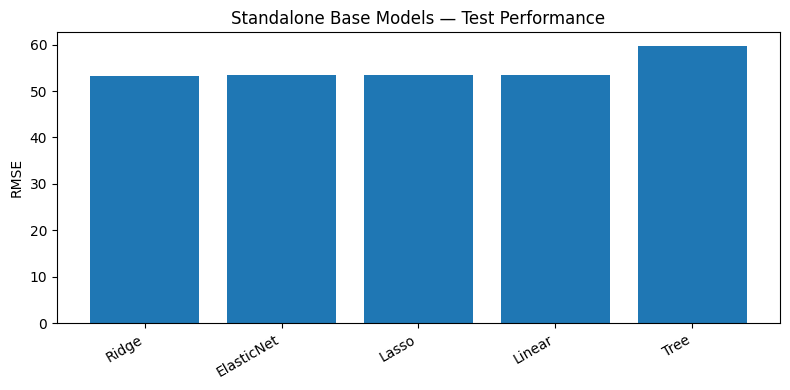

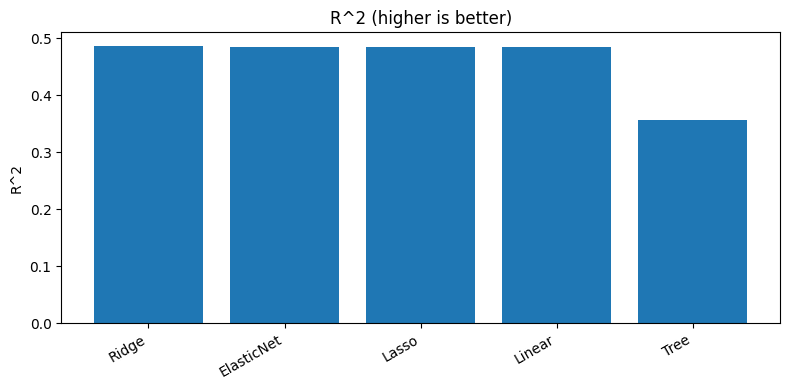

In [6]:

barplot_scores(standalone_df["Model"].tolist(), standalone_df["RMSE"].tolist(), standalone_df["R2"].tolist(),
               title="Standalone Base Models — Test Performance")



## 5) Linear Stacking (with OOF Predictions)

We'll implement K‑fold OOF stacking with a **Ridge** meta‑learner.

### Steps
1. Create $K$ folds on $(X_{\text{train}}, y_{\text{train}})$.
2. For each fold, train each base model on the $K-1$ folds and predict on the held‑out fold to fill the OOF matrix $Z^{\text{OOF}}$.
3. Fit a linear meta‑learner on $(Z^{\text{OOF}}, y_{\text{train}})$.
4. Refit base models on **all** training data, predict on $X_{\text{test}}$, and pass those predictions to the meta‑learner.


In [7]:

def get_oof_predictions(base_models, X, y, n_splits=5, random_state=RANDOM_STATE):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    M = len(base_models)
    Z_oof = np.zeros((len(X), M))
    models_per_fold = {name: [] for name in base_models.keys()}  # optional: keep fold models

    for fold, (tr_idx, val_idx) in enumerate(kf.split(X, y), 1):
        X_tr, X_val = X.iloc[tr_idx], X.iloc[val_idx]
        y_tr, y_val = y.iloc[tr_idx], y.iloc[val_idx]

        for m_idx, (name, model) in enumerate(base_models.items()):
            mdl = Pipeline(model.steps) if isinstance(model, Pipeline) else DecisionTreeRegressor(**model.get_params())
            # Recreate the model to avoid data leakage between folds
            if isinstance(model, Pipeline):
                # Clone pipeline manually to keep simplicity (no sklearn.clone to avoid extra imports)
                new_steps = []
                for step_name, step in model.steps:
                    # Recreate known estimators by type
                    if isinstance(step, StandardScaler):
                        new_steps.append((step_name, StandardScaler()))
                    elif isinstance(step, LinearRegression):
                        new_steps.append((step_name, LinearRegression()))
                    elif isinstance(step, Ridge):
                        new_steps.append((step_name, Ridge(**step.get_params())))
                    elif isinstance(step, Lasso):
                        new_steps.append((step_name, Lasso(**step.get_params())))
                    elif isinstance(step, ElasticNet):
                        new_steps.append((step_name, ElasticNet(**step.get_params())))
                    else:
                        new_steps.append((step_name, step))
                mdl = Pipeline(new_steps)
            else:
                # DecisionTreeRegressor
                mdl = DecisionTreeRegressor(**model.get_params())

            mdl.fit(X_tr, y_tr)
            Z_oof[val_idx, m_idx] = mdl.predict(X_val)
            models_per_fold[name].append(mdl)

    return Z_oof

# Build OOF matrix on TRAIN only
Z_oof = get_oof_predictions(base_learners, X_train, y_train, n_splits=5, random_state=RANDOM_STATE)
Z_oof.shape


(331, 5)

In [8]:

# Fit linear meta-learner (Ridge) on OOF
meta = Ridge(alpha=1.0, random_state=RANDOM_STATE)
meta.fit(Z_oof, y_train)

# Refit base models on ALL training data, then predict TEST
refit_preds_test = []
fitted_base = {}
for name, model in base_learners.items():
    model.fit(X_train, y_train)
    fitted_base[name] = model
    refit_preds_test.append(model.predict(X_test))

Z_test = np.vstack(refit_preds_test).T  # shape (n_test, M)

# Meta predict
y_pred_stack = meta.predict(Z_test)

stack_rmse = rmse(y_test, y_pred_stack)
stack_r2 = r2_score(y_test, y_pred_stack)

print("Stacking — Ridge Meta‑Learner")
print(f"RMSE: {stack_rmse:.4f}")
print(f"R^2:  {stack_r2:.4f}")


Stacking — Ridge Meta‑Learner
RMSE: 53.5607
R^2:  0.4812


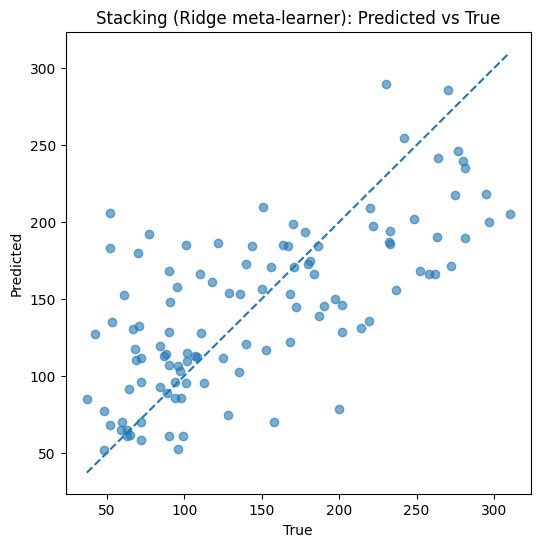

In [9]:

plot_pred_vs_true(y_test, y_pred_stack, title="Stacking (Ridge meta‑learner): Predicted vs True")



## 6) Linear Blending (Hold‑Out)

We will create a **validation split** from the original training data.

**Two approaches:**
1. **Simple weighted average** where weights are proportional to inverse RMSE on the validation set:
   $$
   w_m \propto \frac{1}{\text{RMSE}_m} \quad\text{and}\quad \sum_m w_m = 1.
   $$
2. **Learned linear blender (Ridge)** trained on the validation predictions:
   $$
   \hat{y} \;=\; \beta_0 + \sum_m \beta_m z_m.
   $$


In [10]:

# Make a hold-out validation from the TRAIN split
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=RANDOM_STATE
)

# Fit base models on X_tr and predict on X_val and X_test
val_preds = []
test_preds = []
val_rmses = []
names = []

for name, model in base_learners.items():
    names.append(name)
    model.fit(X_tr, y_tr)
    pv = model.predict(X_val)
    pt = model.predict(X_test)
    val_preds.append(pv)
    test_preds.append(pt)
    val_rmses.append(rmse(y_val, pv))

val_preds = np.vstack(val_preds).T  # (n_val, M)
test_preds = np.vstack(test_preds).T  # (n_test, M)
val_rmses = np.array(val_rmses)

# (1) Simple weighted average by inverse RMSE
inv = 1.0 / np.clip(val_rmses, 1e-8, None)
w = inv / inv.sum()
y_pred_blend_simple = test_preds @ w
blend_simple_rmse = rmse(y_test, y_pred_blend_simple)
blend_simple_r2 = r2_score(y_test, y_pred_blend_simple)

# (2) Learned linear blender (Ridge) on validation predictions
ridge_blender = Ridge(alpha=1.0, random_state=RANDOM_STATE)
ridge_blender.fit(val_preds, y_val)
y_pred_blend_ridge = ridge_blender.predict(test_preds)
blend_ridge_rmse = rmse(y_test, y_pred_blend_ridge)
blend_ridge_r2 = r2_score(y_test, y_pred_blend_ridge)

print("Blending — Simple inverse‑RMSE weights")
print(f"RMSE: {blend_simple_rmse:.4f}, R^2: {blend_simple_r2:.4f}")
print("\nBlending — Ridge blender (learned)")
print(f"RMSE: {blend_ridge_rmse:.4f}, R^2: {blend_ridge_r2:.4f}")

print("\nLearned Ridge blender coefficients (per base model in order):")
for name, coef in zip(names, ridge_blender.coef_):
    print(f"{name:>10s}: {coef:+.4f}")
print(f"Intercept: {ridge_blender.intercept_:+.4f}")


Blending — Simple inverse‑RMSE weights
RMSE: 53.3248, R^2: 0.4858

Blending — Ridge blender (learned)
RMSE: 56.5257, R^2: 0.4222

Learned Ridge blender coefficients (per base model in order):
    Linear: +1.2607
     Ridge: +1.0711
     Lasso: +1.3708
ElasticNet: -3.0020
      Tree: +0.3788
Intercept: +12.0622


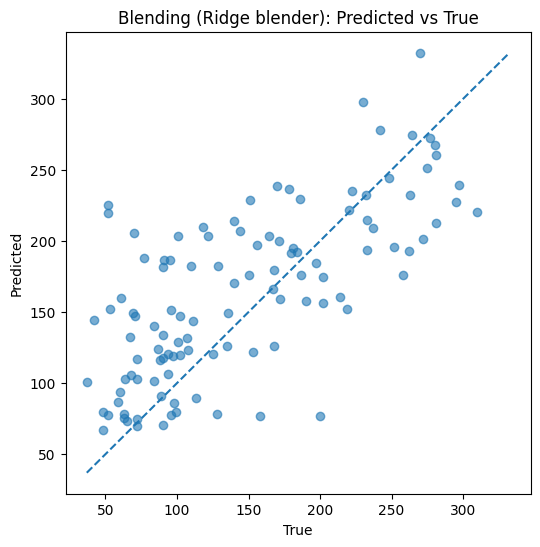

In [11]:

plot_pred_vs_true(y_test, y_pred_blend_ridge, title="Blending (Ridge blender): Predicted vs True")



## 7) Comparison

Let's compare **standalone base models** vs **stacking** vs **blending** on the same held‑out test set.


In [12]:

results = standalone_df.copy()
results = pd.concat([
    results,
    pd.DataFrame([
        {"Model": "Stacking (Ridge meta)", "RMSE": stack_rmse, "R2": stack_r2},
        {"Model": "Blending (simple)", "RMSE": blend_simple_rmse, "R2": blend_simple_r2},
        {"Model": "Blending (Ridge)", "RMSE": blend_ridge_rmse, "R2": blend_ridge_r2},
    ])
], ignore_index=True).sort_values("RMSE").reset_index(drop=True)

results


,Model,RMSE,R2
0,Ridge,53.318239,0.485896
1,Blending (simple),53.324762,0.485770
2,ElasticNet,53.357196,0.485145
3,Lasso,53.368488,0.484927
4,Linear,53.369567,0.484906
5,Stacking (Ridge meta),53.560737,0.481209
6,Blending (Ridge),56.525743,0.422181
7,Tree,59.651587,0.356508


In [14]:
# from caas_jupyter_tools import display_dataframe_to_user
# display_dataframe_to_user("All Models — Test Comparison", results)
display(results)

,Model,RMSE,R2
0,Ridge,53.318239,0.485896
1,Blending (simple),53.324762,0.485770
2,ElasticNet,53.357196,0.485145
3,Lasso,53.368488,0.484927
4,Linear,53.369567,0.484906
5,Stacking (Ridge meta),53.560737,0.481209
6,Blending (Ridge),56.525743,0.422181
7,Tree,59.651587,0.356508


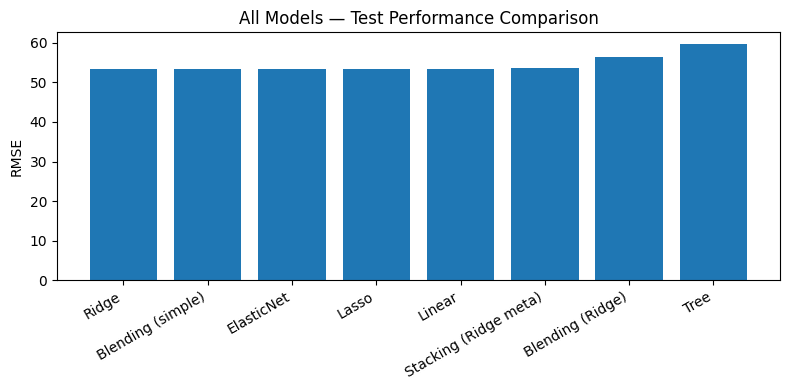

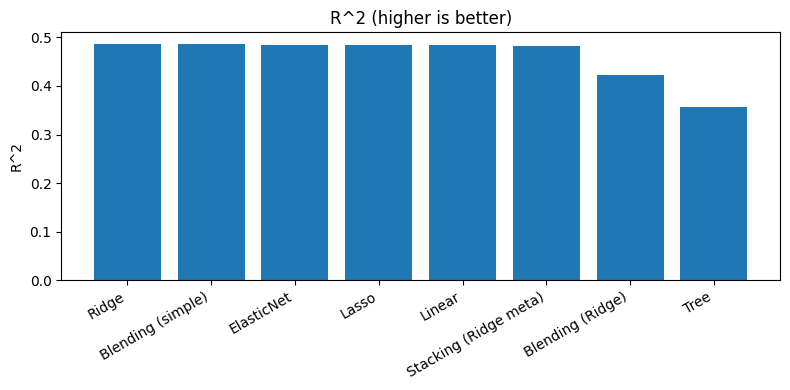

In [15]:

barplot_scores(results["Model"].tolist(), results["RMSE"].tolist(), results["R2"].tolist(),
               title="All Models — Test Performance Comparison")



## 8) (Optional) Using `StackingRegressor` for Convenience

To validate our manual implementation, we can use scikit‑learn's `StackingRegressor` with a linear final estimator.


StackingRegressor (sklearn)
RMSE: 53.0452
R^2:  0.4911


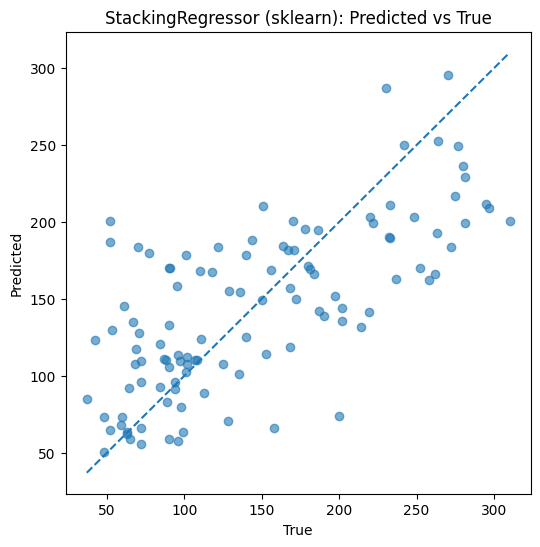

In [16]:

from sklearn.ensemble import StackingRegressor

estimators = []
for name, model in base_learners.items():
    estimators.append((name, model))

stack_skl = StackingRegressor(
    estimators=estimators,
    final_estimator=Ridge(alpha=1.0, random_state=RANDOM_STATE),
    passthrough=False,   # set True to add original features to meta-learner
    n_jobs=None
)

stack_skl.fit(X_train, y_train)
y_pred_stack_skl = stack_skl.predict(X_test)

print("StackingRegressor (sklearn)")
print(f"RMSE: {rmse(y_test, y_pred_stack_skl):.4f}")
print(f"R^2:  {r2_score(y_test, y_pred_stack_skl):.4f}")

plot_pred_vs_true(y_test, y_pred_stack_skl, title="StackingRegressor (sklearn): Predicted vs True")



## 9) Practical Tips & Pitfalls

- **Correct OOF generation** is crucial. Never train base models on the same data used to create meta‑training targets.  
- Use a **linear meta‑learner** (Ridge/Lasso/ElasticNet) when you want interpretability and stability; try regularization for small $n$ or collinear base predictions.  
- For **blending**, the validation split should be **stratified** (for classification) or representative; otherwise weights may overfit the hold‑out.  
- Consider **passthrough=True** in `StackingRegressor` to feed original features to the meta‑learner (not strictly linear blending anymore).  
- Start simple: a **two‑model** blend often captures most gains (e.g., a linear model + a tree).  
- Always compare to a **strong single model** baseline.
